In [58]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import random
import os
import pandas as pd
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split
from scipy.stats import ks_2samp
from itertools import combinations
from rich.progress import track

def remove_transient(df, threshold_multiplier=4):

    median = df.median()
    mad = np.median(np.abs(df - median))

    dynamic_threshold = median + threshold_multiplier * mad

    # ? Split data into 25% and 75% based on time
    try:
        df_25, df_75 = train_test_split(df, test_size=0.75, shuffle=False)
    except ValueError:
        return None

    # ? Remove transients from first 25% of the data
    df_25 = df_25.apply(lambda x: x if x <= dynamic_threshold else np.nan)
    df_25.dropna(inplace=True)

    # ? Combine df_25 and df_75 back together
    df_combined = pd.concat([df_25, df_75])

    return df_combined    

datadir = "C:/Users/kalee/Documents/phd_data/3pi/ml_data/qos_capture_ps_2_summaries"

csv_files = [os.path.join(datadir, f) for f in os.listdir(datadir) if f.endswith(".csv")]


# Visual Inspection

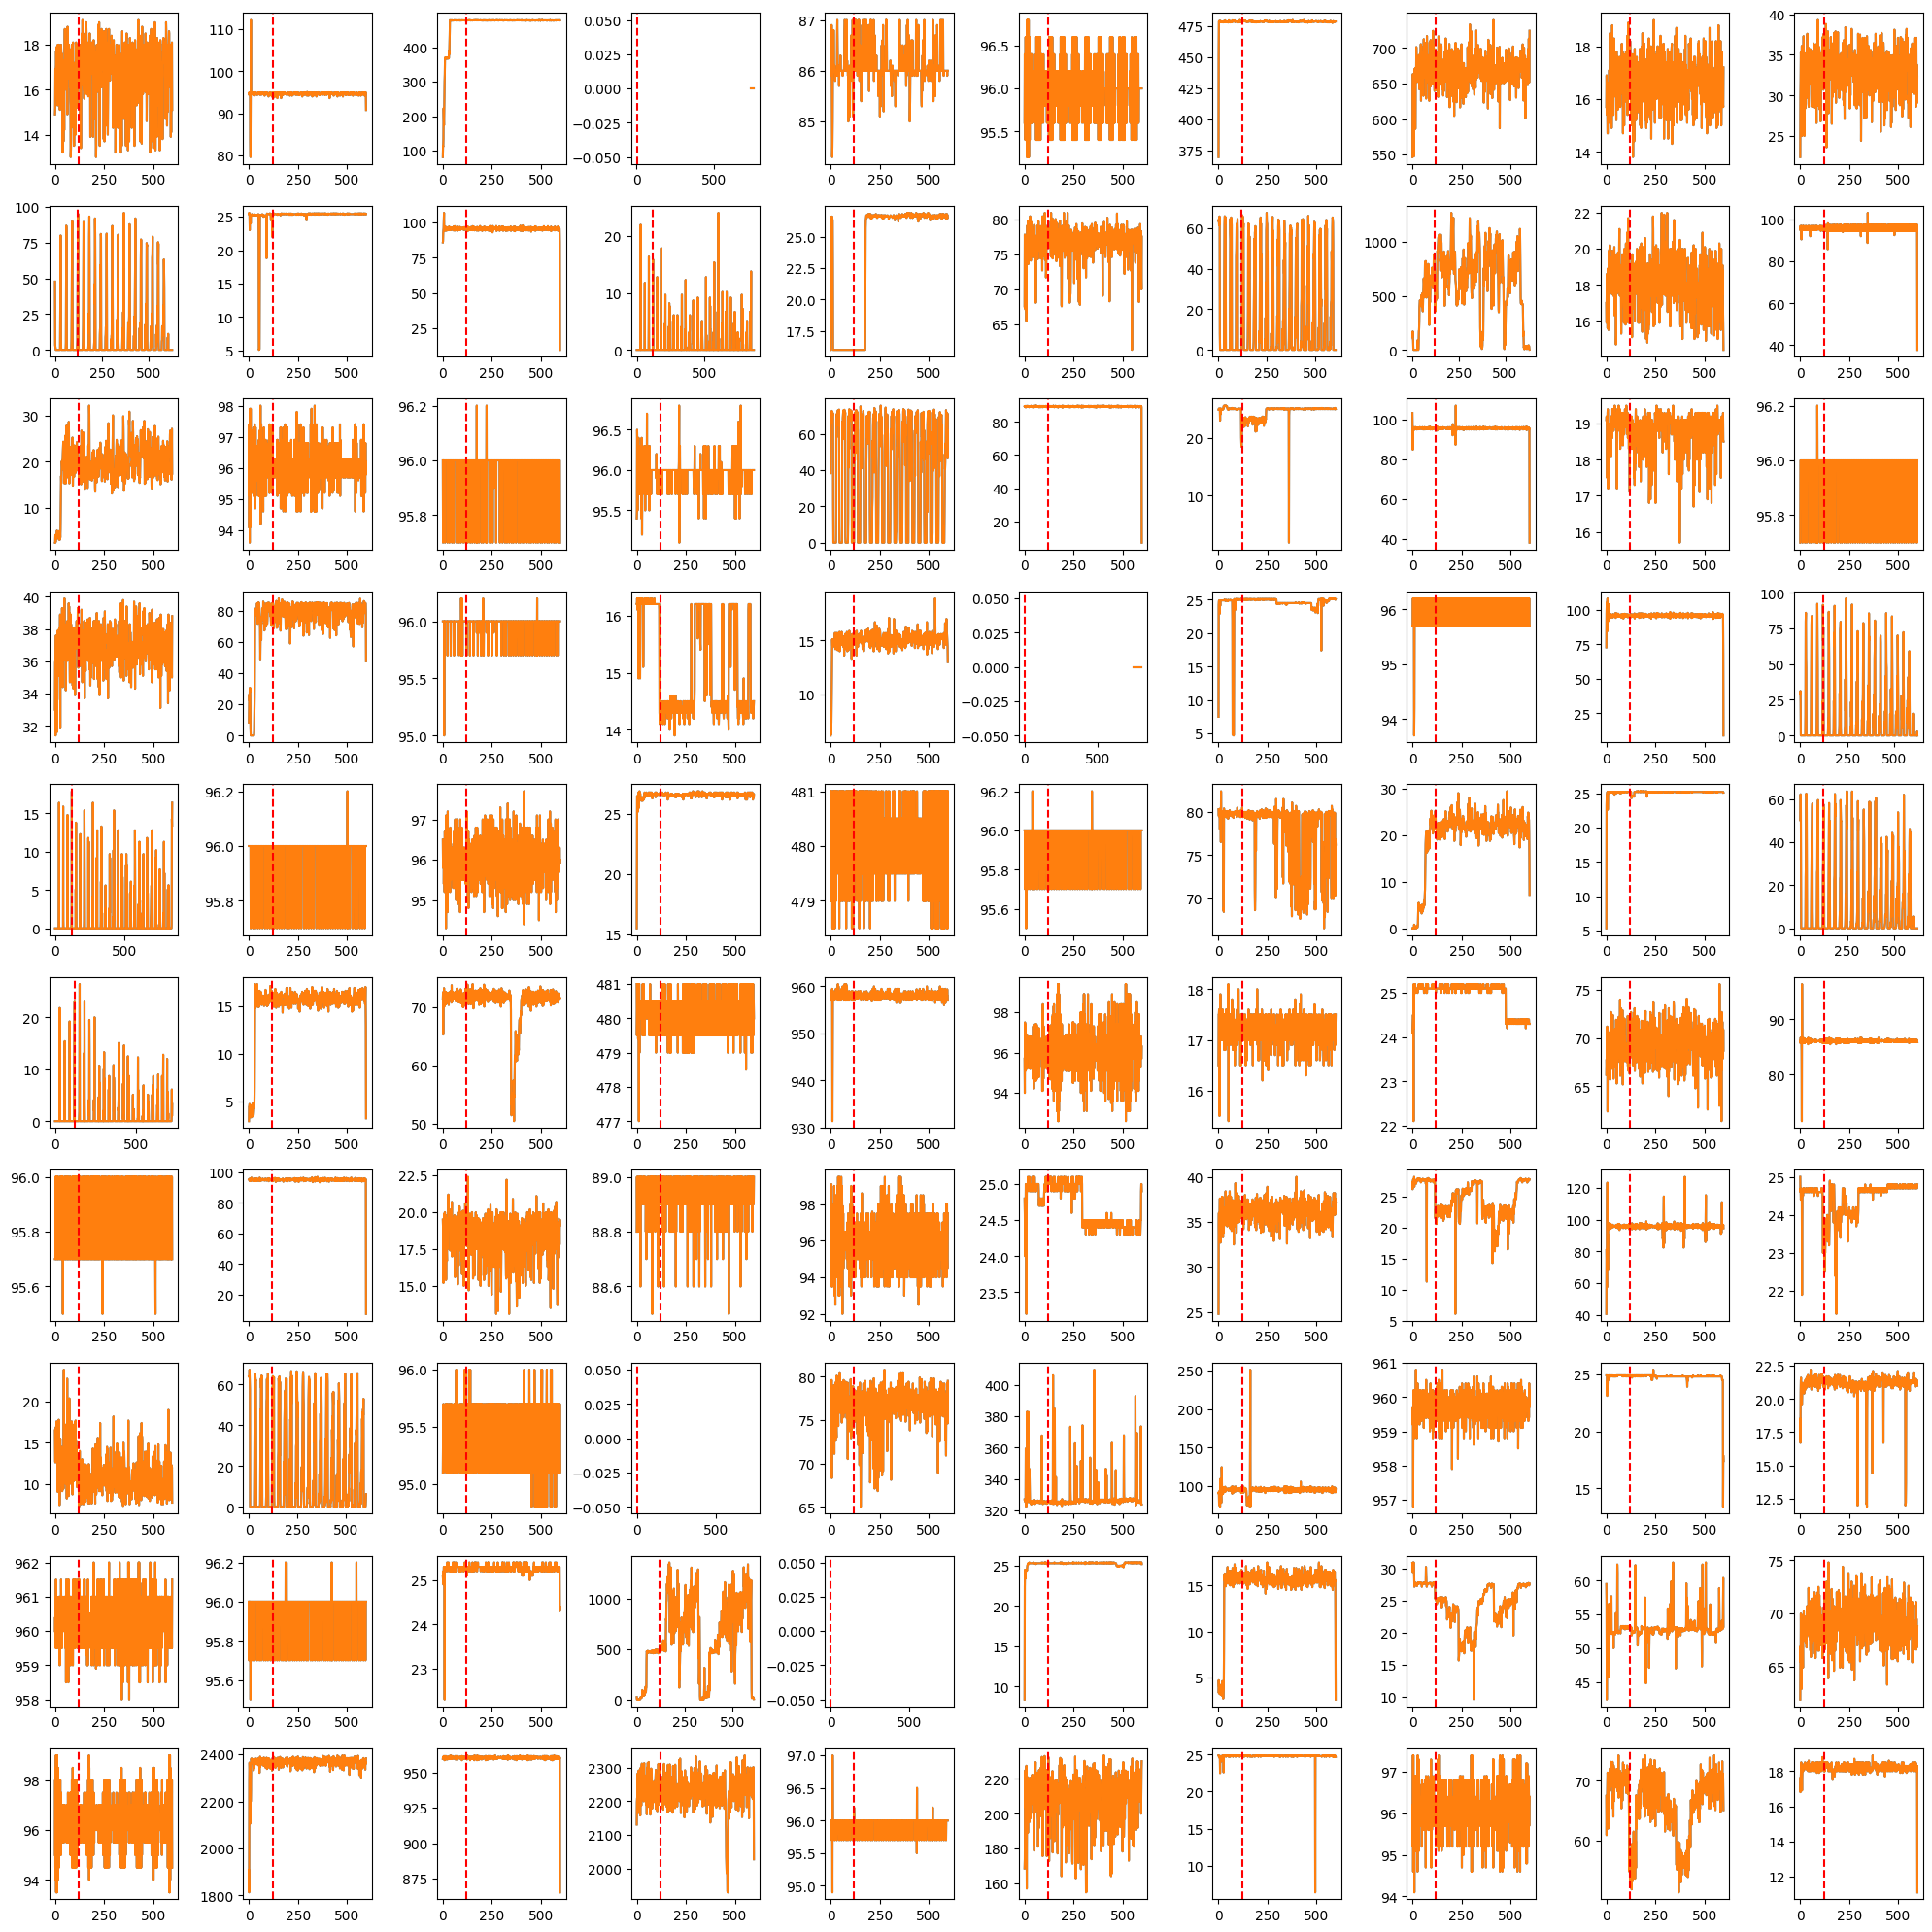

In [115]:
row_count = 10

random_files = random.sample(csv_files, row_count*row_count)

fig, axs = plt.subplots(row_count, row_count, figsize=(20, 20))

for i, file in enumerate(random_files):
    try:
        df = pd.read_csv(file)
        tp_col = [col for col in df.columns if 'total_mbps' in col.lower()][0]
        df = df[tp_col]
        df = df.dropna()
        df = df.astype(float)
        new_column_name = os.path.basename(file).split(".")[0].replace("_summary", "") + "_total_mbps"
        df = df.rename(new_column_name)
        
        axs[i//row_count, i%row_count].plot(df)
        axs[i//row_count, i%row_count].plot(df)
        # std = df.std()
        # std *= 1.5
        # axs[i//row_count, i%row_count].axhline(df.mean() + std, color='r', linestyle='--')
        # axs[i//row_count, i%row_count].axhline(df.mean() - std, color='r', linestyle='--')

        # Draw a vertical line at 10% of the x axis
        x_limit = 120 if df.shape[0] > 120 else df.shape[0] * .1
        axs[i//row_count, i%row_count].axvline(x_limit, color='red', linestyle='--')

    except Exception as e:
        continue

plt.tight_layout()
plt.show()

# Autocorrelation

In [114]:
def get_transient_durations_using_autocorr(files):
    
    transient_durations = []

    for file in track(files, description="Calculating transient durations..."):
        try:
            df = pd.read_csv(file)
            latency_col = [col for col in df.columns if 'latency' in col.lower()][0]
            df = df[latency_col]
            df = df.dropna()
            df = df.astype(float)
            df = df/1000
            new_column_name = os.path.basename(file).split(".")[0].replace("_summary", "") + "_latency_ms"
            df = df.rename(new_column_name)
            
            try:
                df_25, df_75 = train_test_split(df, test_size=0.75, shuffle=False)
            except ValueError:
                continue

            autocorr = np.correlate(df, df, mode='full') / np.sum(df ** 2)

            big_spikes = np.where(autocorr > 0.2)[0]
            cut_off_point = big_spikes[0]
            cut_off_percent = cut_off_point / len(df)
            cut_off_percent = int(cut_off_percent * 100)

            new_row = {
                "file": os.path.basename(file),
                "cut_off_percent": cut_off_percent,
                "cut_off_point": cut_off_point,
                "total_points": len(df),
            }

            transient_durations.append(new_row)
        except Exception as e:
            continue

    transient_durations = pd.DataFrame(transient_durations)

    return transient_durations

## Autocorrelation Demonstration

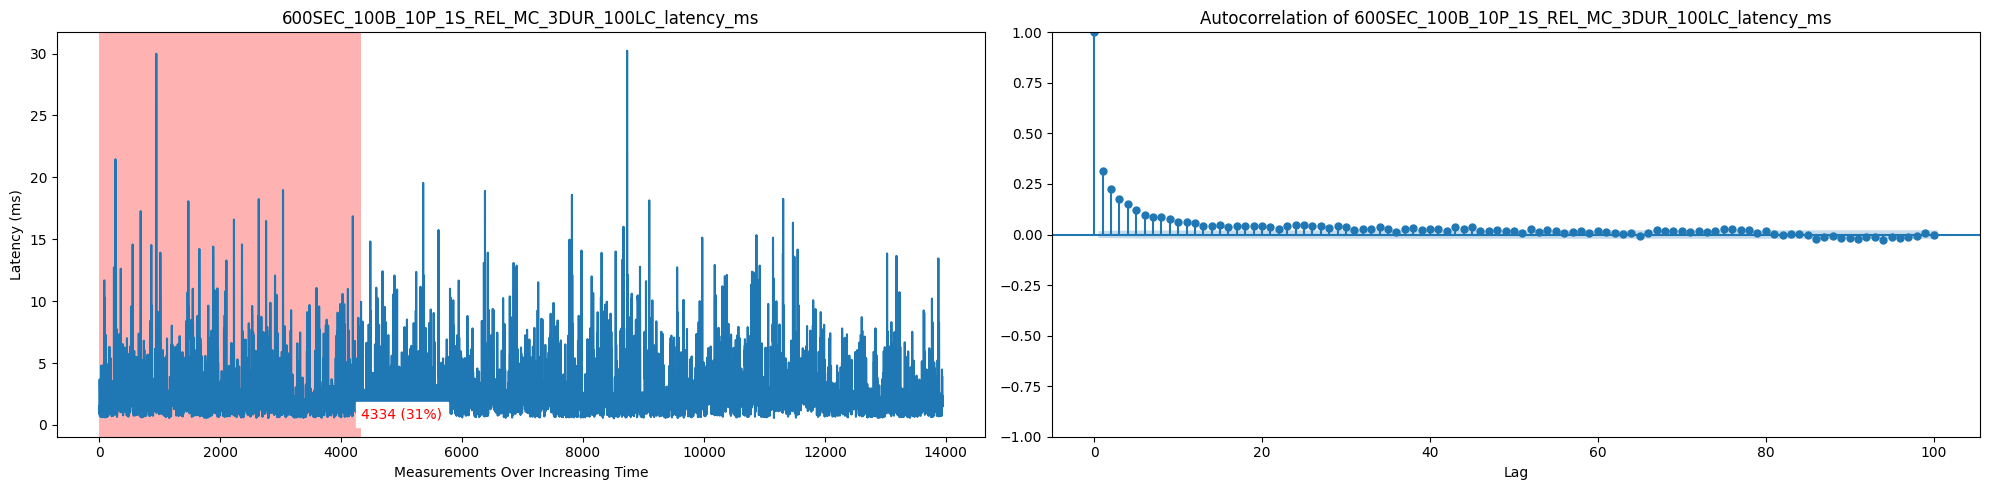

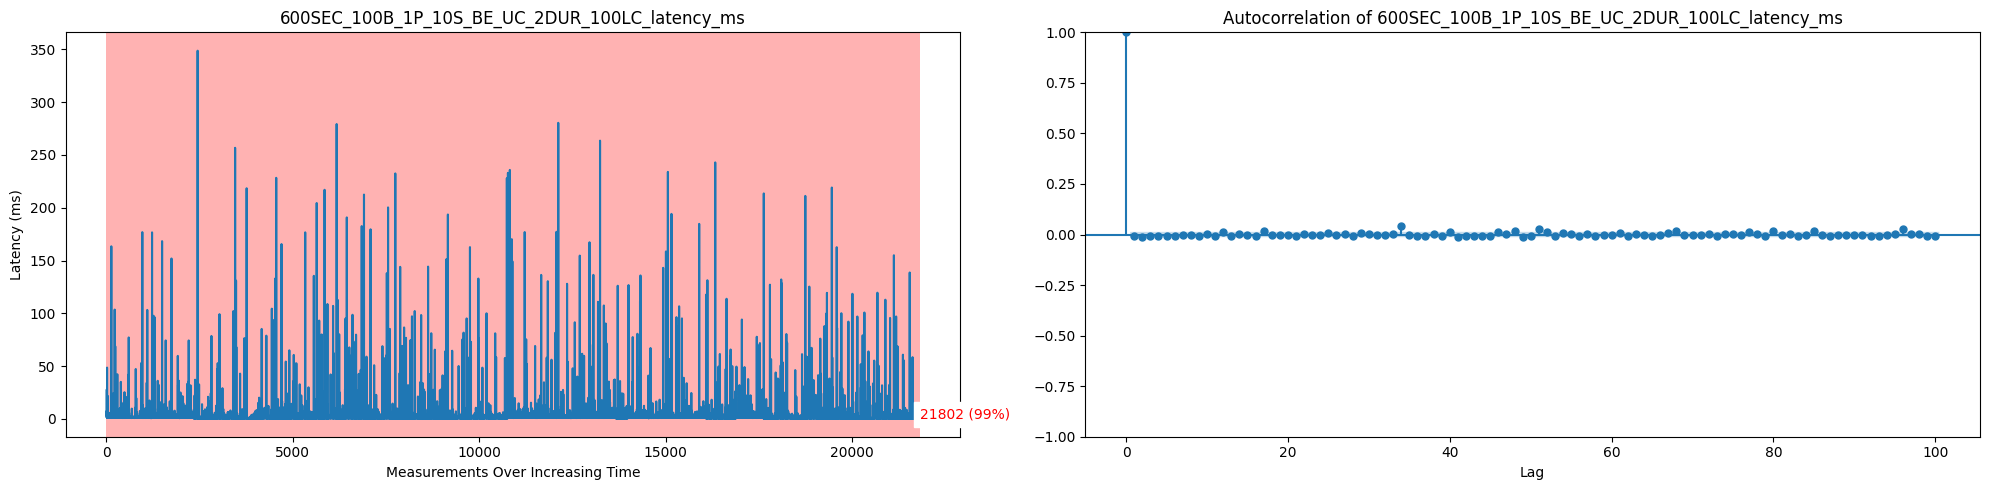

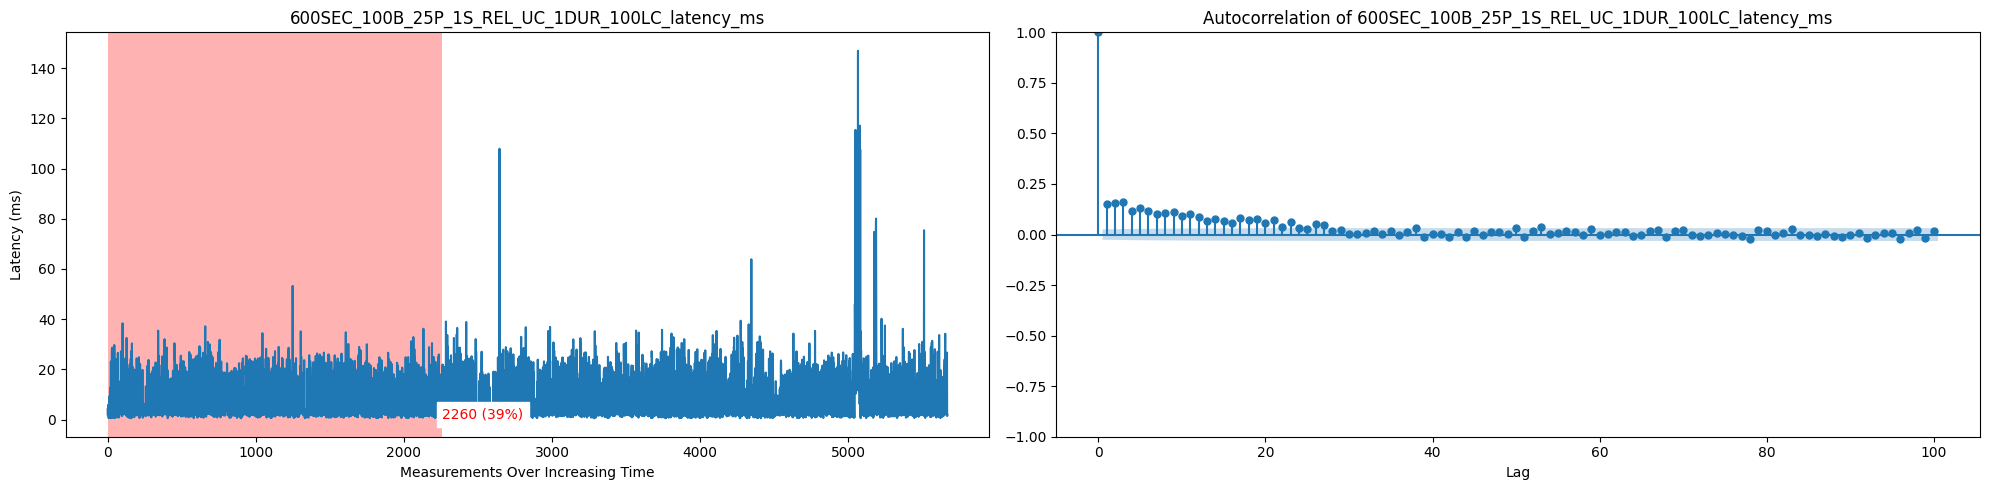

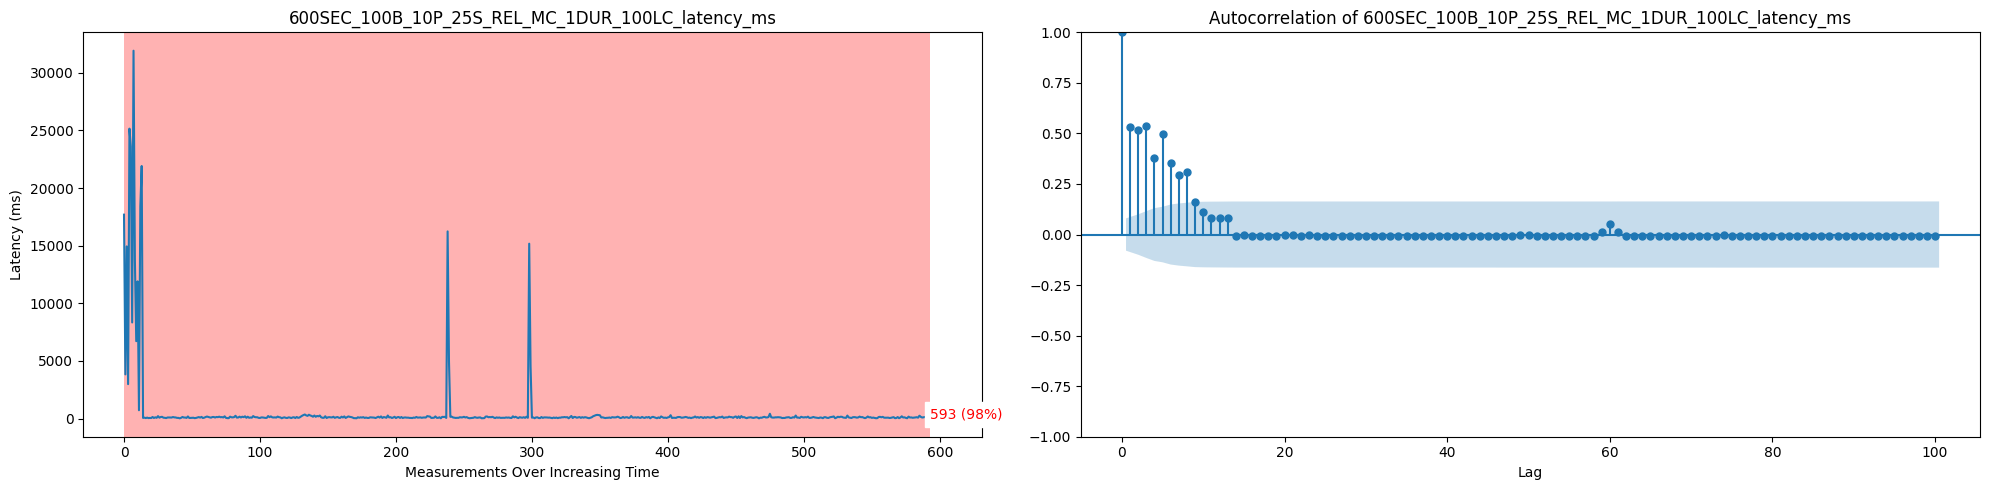

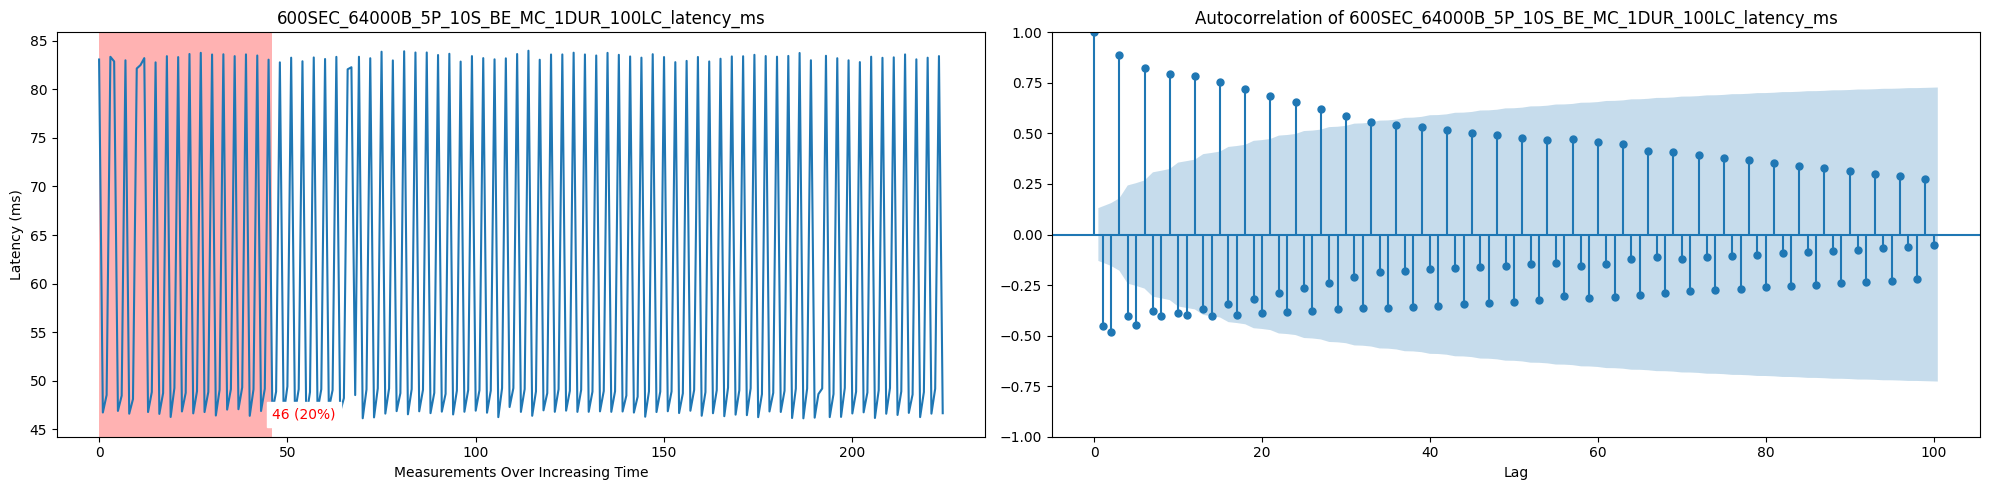

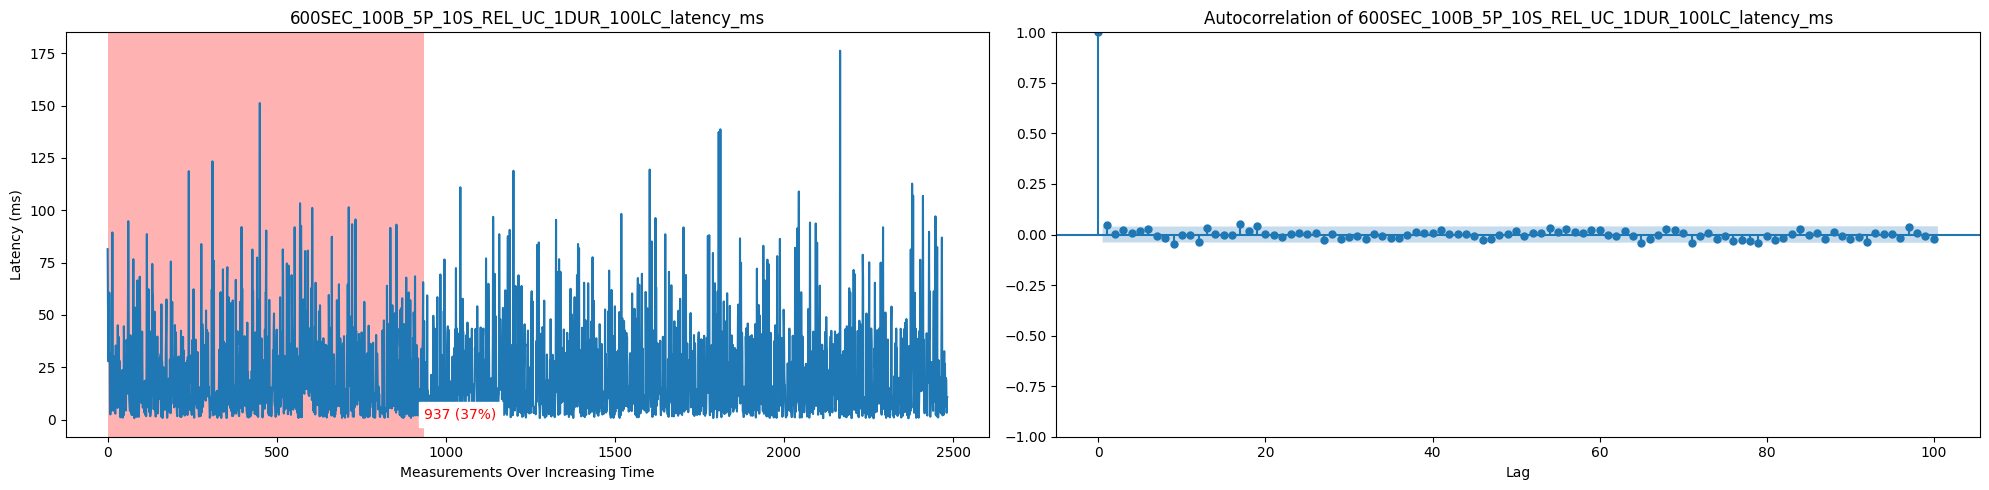

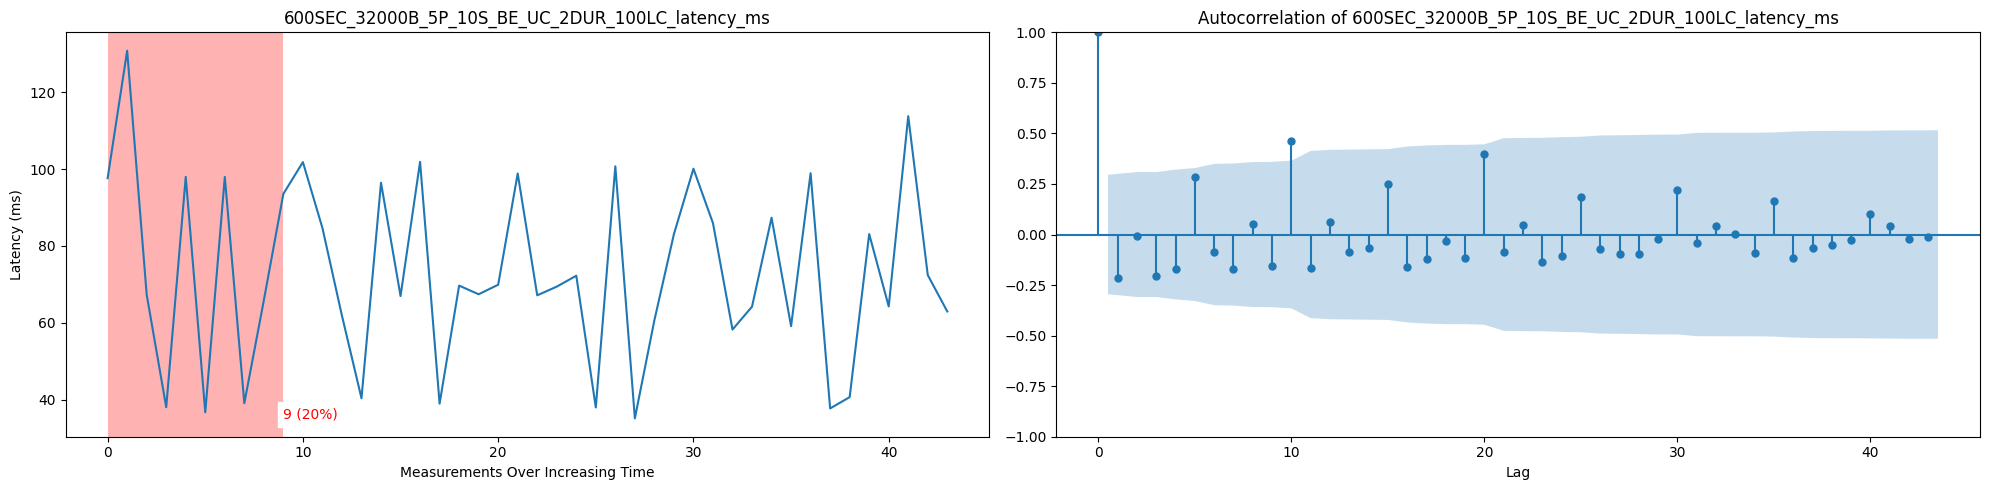

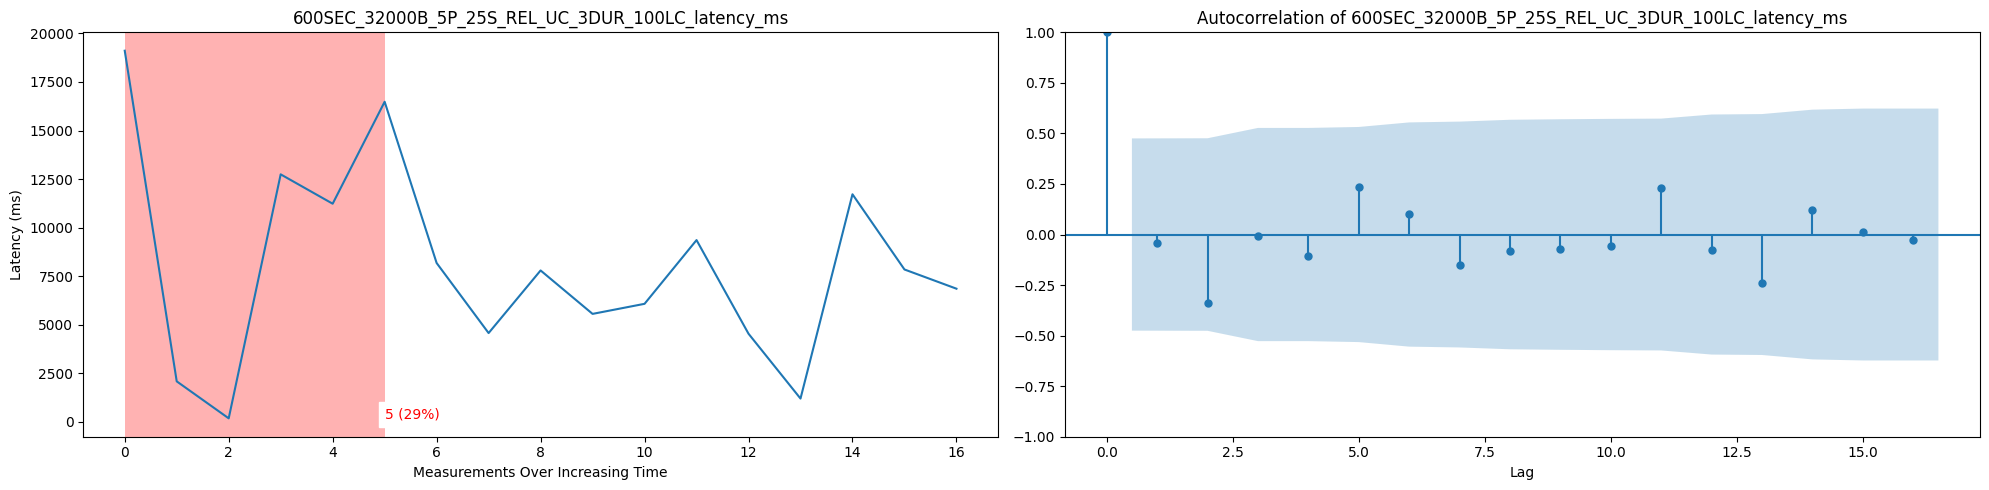

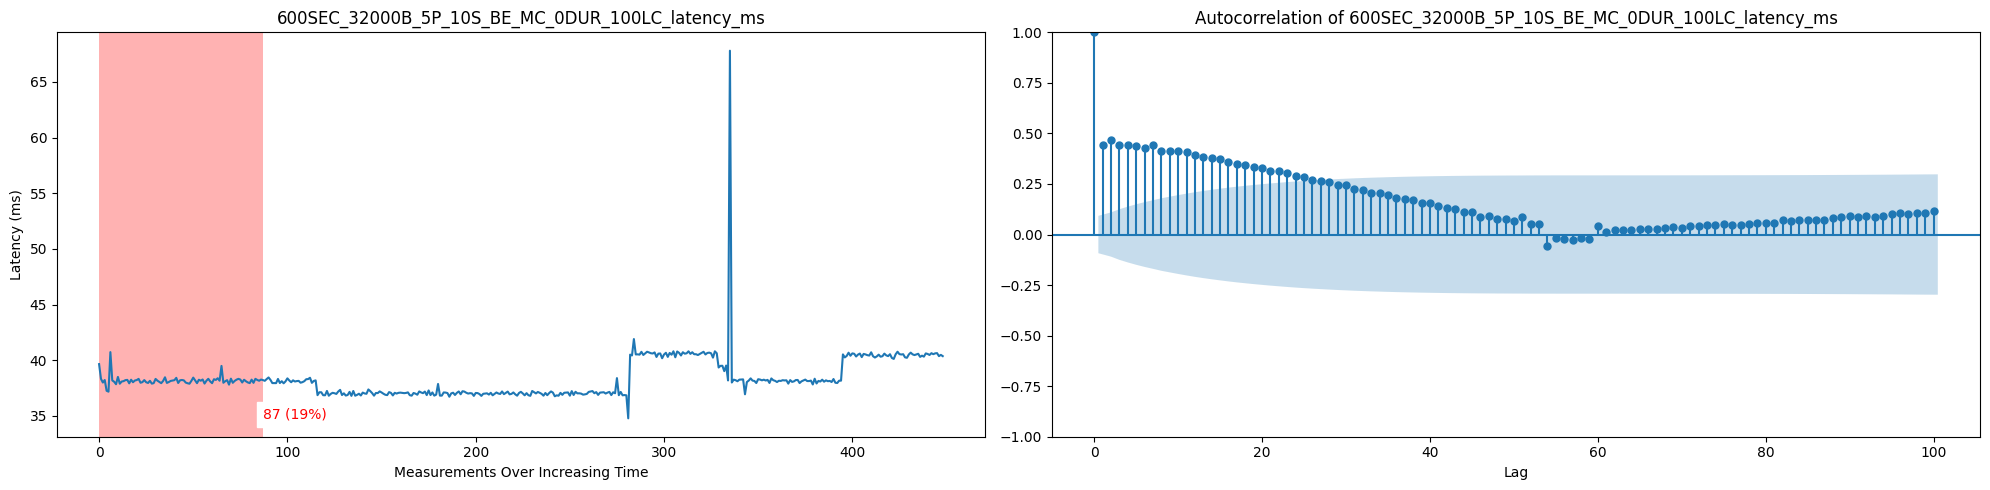

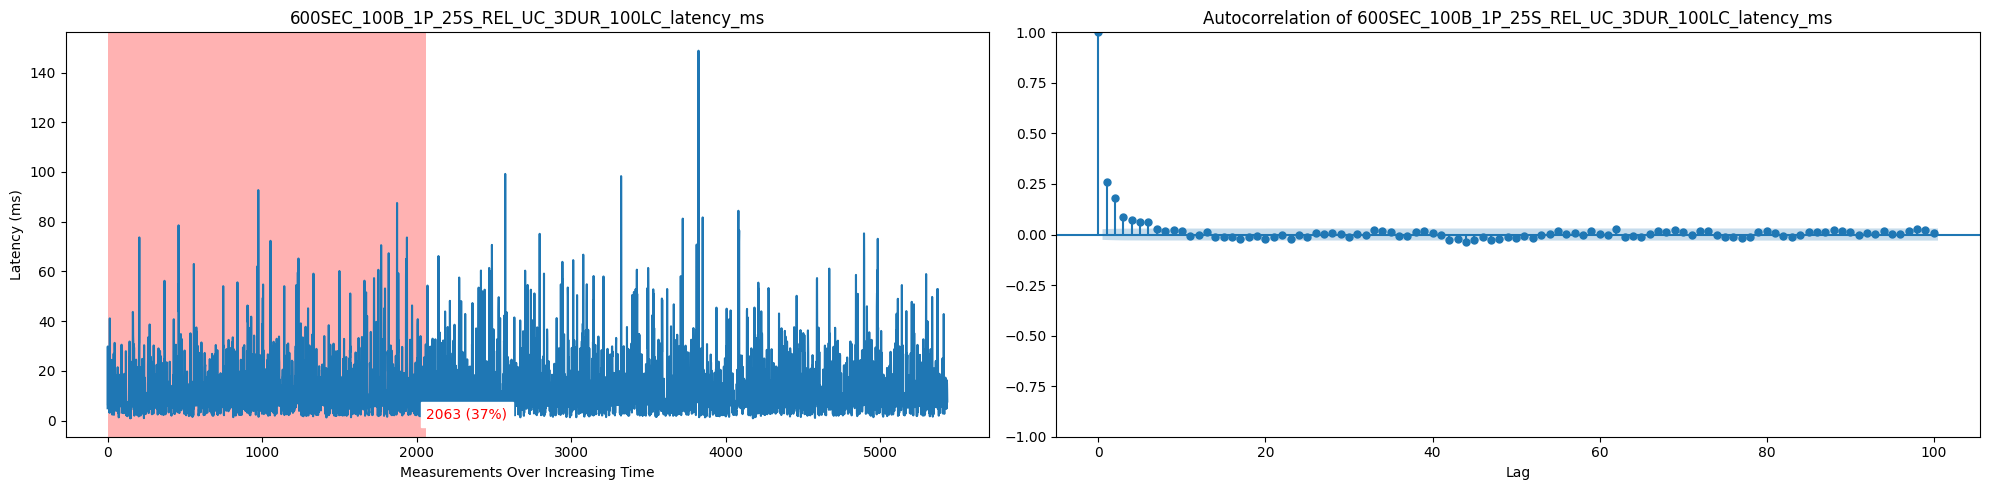

In [85]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
random_files = random.sample(csv_files, 10)

for file in random_files:
    df = pd.read_csv(file)
    latency_col = [col for col in df.columns if 'latency' in col.lower()][0]
    df = df[latency_col]
    df = df.dropna()
    df = df.astype(float)
    df = df/1000
    new_column_name = os.path.basename(file).split(".")[0].replace("_summary", "") + "_latency_ms"
    df = df.rename(new_column_name)
    
    try:
        df_25, df_75 = train_test_split(df, test_size=0.75, shuffle=False)
    except ValueError:
        continue

    autocorr = np.correlate(df, df, mode='full') / np.sum(df ** 2)

    big_spikes = np.where(autocorr > 0.2)[0]
    cut_off_point = big_spikes[0]
    cut_off_percent = cut_off_point / len(df)
    cut_off_percent = int(cut_off_percent * 100)

    lags = 100 if len(df) > 100 else len(df)-1
    
    fig, axs = plt.subplots(1, 2, figsize=(20, 5))

    axs[0].plot(df)
    axs[0].set_title(f"{new_column_name}")
    axs[0].set_xlabel("Measurements Over Increasing Time")
    axs[0].set_ylabel("Latency (ms)")
    axs[0].axvspan(0, cut_off_point, facecolor='red', alpha=0.3)
    axs[0].text(cut_off_point, min(df), f"{cut_off_point} ({cut_off_percent}%)", color='red', backgroundcolor='white')

    plot_acf(df, ax=axs[1], lags=lags)
    axs[1].set_title(f"Autocorrelation of {new_column_name}")
    axs[1].set_xlabel("Lag")

    plt.tight_layout()
    plt.show()

## How many tests are cutting out more than 25% of the data?

For every test I've calculated the transient duration using autocorrelation and have the following data per test:
- file: the file
- cut off percent: what percent of the data should be cut off because its considered transient
- cut off point: the exact point where all values up to the point fall within the transient period
- total points: all measurements in total

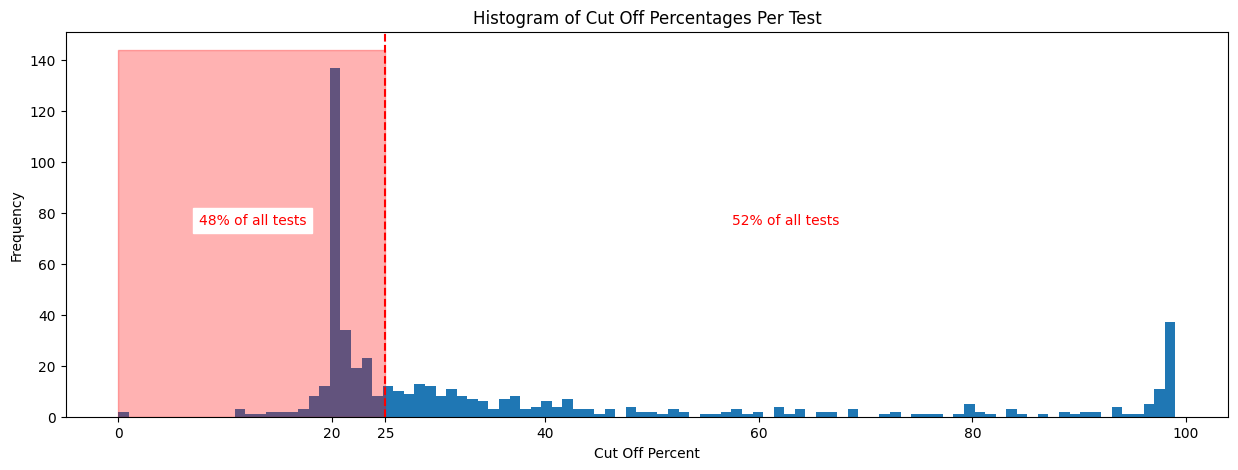

In [162]:
transient_df = pd.read_csv('transient_df.csv')

fig, ax = plt.subplots(figsize=(15, 5))

cut_off_under_25 = transient_df[transient_df['cut_off_percent'] < 25]
num_rows_under_25 = len(cut_off_under_25)
percent_under_25 = num_rows_under_25 / len(transient_df) * 100
percent_under_25 = int(percent_under_25)

transient_df['cut_off_percent'].plot(kind='hist', bins=100, ax=ax)
ax.set_xlabel('Cut Off Percent')
ax.set_ylabel('Frequency')
_ = ax.set_title('Histogram of Cut Off Percentages Per Test')

xt = ax.get_xticks()
xt = np.append(xt, 25)
ax.set_xticks(xt)

ax.axvline(25, color='red', linestyle='--')
ax.fill_betweenx(ax.get_ylim(), 0, 25, color='red', alpha=0.3)
ax.text(7.5, max(ax.get_ylim()) * 0.5, f"{percent_under_25}% of all tests", color='red', backgroundcolor='white')
ax.text(57.5, max(ax.get_ylim()) * 0.5, f"{100 - percent_under_25}% of all tests", color='red', backgroundcolor='white')

plt.show()

# Threshold

## Threshold Demonstration

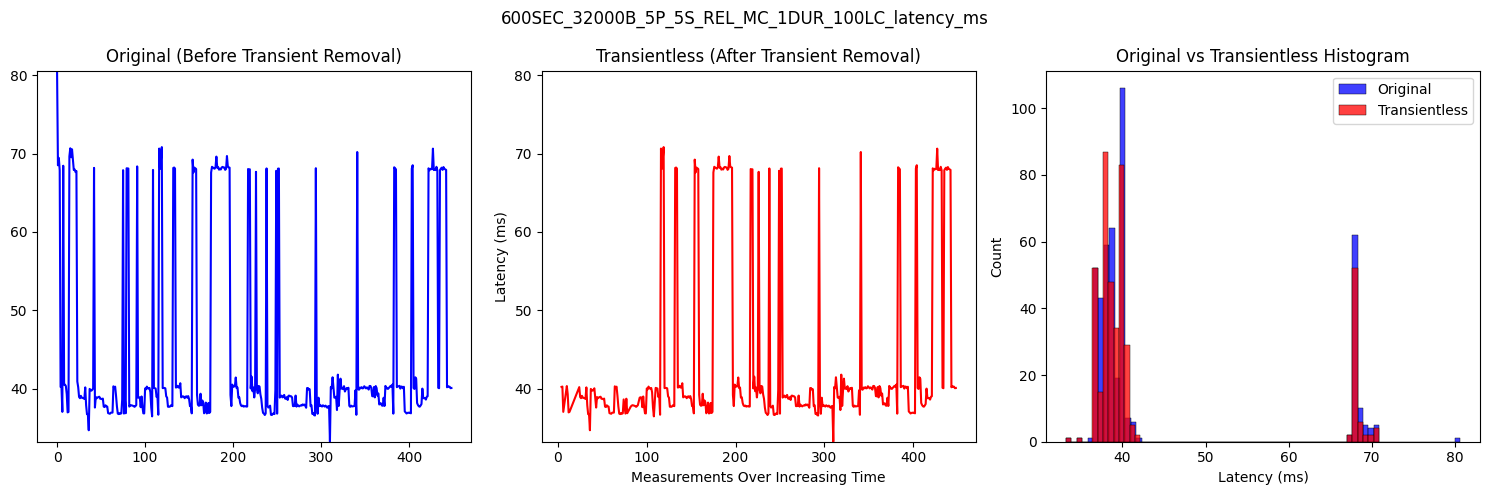

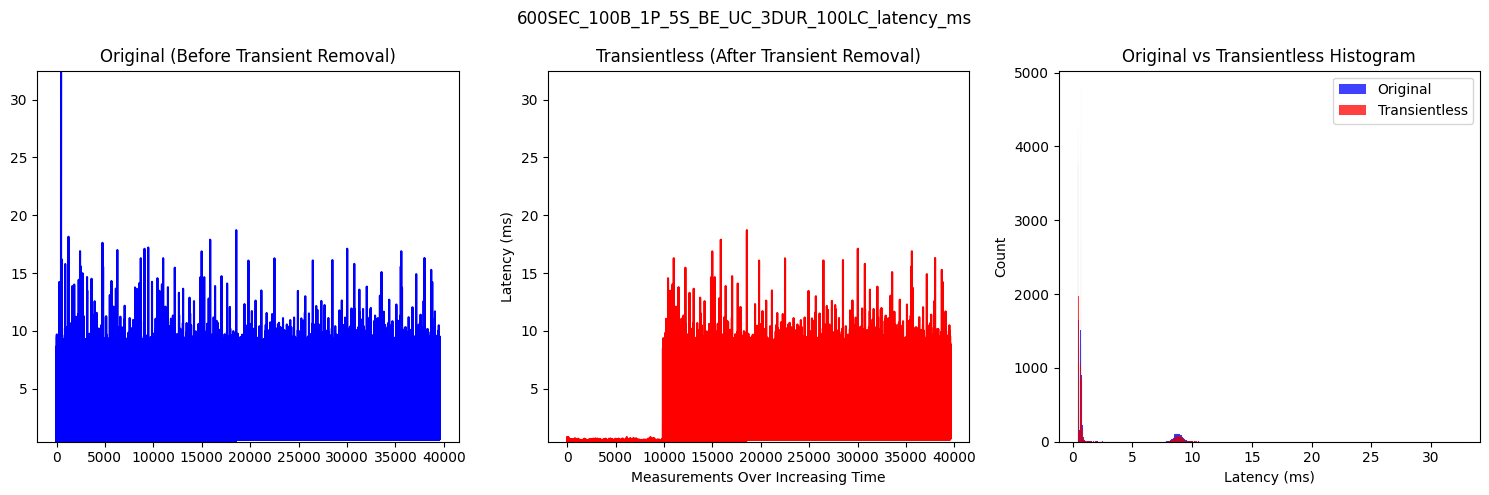

In [86]:
random_files = random.sample(csv_files, 2)

for file in random_files:
    df = pd.read_csv(file)
    latency_col = [col for col in df.columns if 'latency' in col.lower()][0]
    df = df[latency_col]
    df = df.dropna()
    df = df.astype(float)
    df = df/1000
    new_column_name = os.path.basename(file).split(".")[0].replace("_summary", "") + "_latency_ms"
    df = df.rename(new_column_name)
    
    try:
        df_25, df_75 = train_test_split(df, test_size=0.75, shuffle=False)
    except ValueError:
        continue

    transientless_df = remove_transient(df, 1)
    if transientless_df is None:
        continue

    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle(new_column_name)

    # ? Transientless - Time Series
    axs[0].plot(df.index, df, color='blue')
    axs[0].set_title('Original (Before Transient Removal)')
    axs[0].set_ylim(min(df), max(df))
    
    axs[1].plot(transientless_df.index, transientless_df, color='red')
    axs[1].set_title('Transientless (After Transient Removal)')
    axs[1].set_ylim(min(df), max(df))
    axs[1].set_ylabel('Latency (ms)')
    axs[1].set_xlabel('Measurements Over Increasing Time')

    # ? Transient Removal - Histograms
    sns.histplot(df, ax=axs[2], color='blue', label='Original')
    sns.histplot(transientless_df, ax=axs[2], color='red', label='Transientless')
    axs[2].set_title('Original vs Transientless Histogram')
    axs[2].legend()
    axs[2].set_xlabel('Latency (ms)')

    plt.tight_layout()
    plt.show()

# Windowed Distribution Comparison

I split the data into x parts and compare the distributions of each parts together to see how different they are.

C:\Users\kalee\AppData\Local\Temp\ipykernel_19432\4199958493.py:63: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


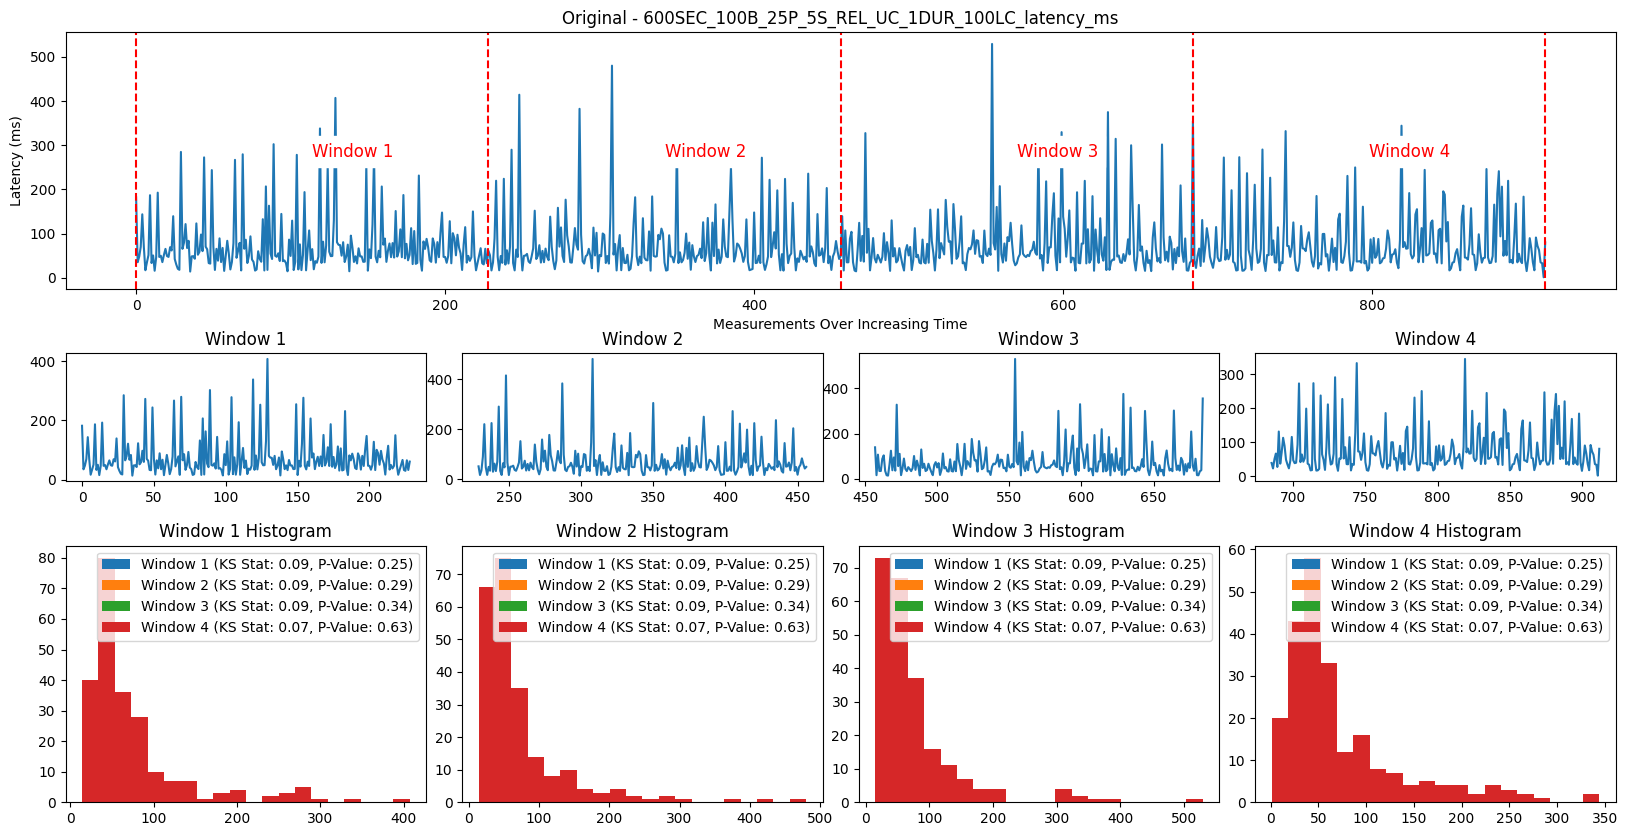

In [81]:
random_files = random.sample(csv_files, 1)

window_fractions = [4]

for file in random_files:
    df = pd.read_csv(file)
    latency_col = [col for col in df.columns if 'latency' in col.lower()][0]
    df = df[latency_col]
    df = df.dropna()
    df = df.astype(float)
    df = df/1000
    new_column_name = os.path.basename(file).split(".")[0].replace("_summary", "") + "_latency_ms"
    df = df.rename(new_column_name)

    for window_fraction in window_fractions:
        df_parts = np.array_split(df, window_fraction, axis=0)

        window_panes = [0]
        for i in range(len(df_parts)):
            window_panes.append(df_parts[i].index[-1])

        fig = plt.figure(figsize=(20, 10))
        gs = gridspec.GridSpec(3, 1, height_ratios=[2, 1, 2], hspace=0.3)

        wide_ax = fig.add_subplot(gs[0, 0])
        wide_ax.plot(df)
        wide_ax.set_title(f'Original - {new_column_name}')
        wide_ax.set_xlabel('Measurements Over Increasing Time')
        wide_ax.set_ylabel('Latency (ms)')
        for pane in window_panes:
            wide_ax.axvline(x=pane, color='red', linestyle='--')
            if pane != 0:
                pane_index = window_panes.index(pane)
                wide_ax.text((pane + window_panes[pane_index - 1]) / 2, (df.max() + df.min()) / 2, f'Window {window_panes.index(pane)}', verticalalignment='bottom', color='red', backgroundcolor='white', fontsize=12)

        sub_gs = gs[1].subgridspec(1, len(df_parts), wspace=0.1)
        for i in range(len(df_parts)):
            ax = fig.add_subplot(sub_gs[0, i])
            ax.plot(df_parts[i], label=f'Window {i+1}')
            ax.set_title(f'Window {i+1}')
            # ax.set_xlabel('Measurements Over Increasing Time')
            # ax.set_ylabel('Latency (ms)')

        sub_gs = gs[2].subgridspec(1, len(df_parts), wspace=0.1)
        for i in range(len(df_parts)):
            dist_combs = list(combinations(df_parts, 2))

            ax = fig.add_subplot(sub_gs[0, i])
            ax.set_title(f'Window {i+1} Histogram')

            labels = []
            for j, (dist1, dist2) in enumerate(dist_combs):
                if j in [0, 1]:
                    continue
                ks_stat, p_value = ks_2samp(dist1, dist2)
                ax.hist(df_parts[i], bins=20, label=f'Window {j - 1} (KS Stat: {ks_stat:.2f}, P-Value: {p_value:.2f})')

            ax.legend()
            # ax.set_xlabel('Latency (ms)')
            # ax.set_ylabel('Frequency')

        # Adjust layout and display the plot
        plt.tight_layout()
        plt.show()